<a href="https://colab.research.google.com/github/bilalrahim/Fake-News-Text-Classification-Using-CNN-and-Word-Embeddings/blob/main/Fake_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Fake news using word embeddings and CNN.

## Steps include

*   Data Pre processing
  *   Removing Stop words and Punctuation.
  *   Removing White Spaces.
  *   Removing URL's

*  Splitting data into test train.
*  Tokenization of data.
*  Training embedding layer with the given dataset.
*  Training CNN model on the dataset.
*  Plotting ROC and calculating AUC.
*  Ranking top 10 words associated with real news articles and fake news articles.
*   Model Improvement suggestion.


In [18]:
# Setup

import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import nltk
nltk.download('stopwords')
from string import punctuation as punc
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Setting up GPU for training Model.
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Changes to Dataset : 

*   'labels' column is added to true news and fake news dataset.
*   Both the datasets are merged into single dataframe and shuffled.
*   Title column is merged into text as they conveyed somewhat similar text.
*   Columns date, subject and title are dropped.
*   Data is split into train test. 80% for training and 20% of testing.








In [20]:
# Importing Dataset.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
true_news = pd.read_csv('/content/drive/My Drive/Data Sets/True.csv')
false_news = pd.read_csv('/content/drive/My Drive/Data Sets/Fake.csv')

In [22]:
# Combining both the datasets.
# To differentiate between fake new and true new we will add another column with labels [0, 1].
# 0 is for fake and 1 is for true.
# For word Embeddings the columns 'subject and date' are useless.
# and will merge title and text into single column.

true_news['label'] = 1
false_news['label'] = 0
corpus = pd.concat([true_news,false_news])
corpus = corpus.sample(frac = 1)
corpus['text'] = corpus['title'] + corpus['text']

del corpus['title']
del corpus['subject']
del corpus['date']

In [23]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Apply function on review column
corpus['text']=corpus['text'].apply(strip_html)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpghttps://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpghttps://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://10

In [24]:
# Removing stop words.
# removing punctuation and extra white spaces.

def clean_text(text):
  cleaned_text = []
  text = text.split(' ')
  for word in text:
    if word not in stop_words or punc:
      if word != ' ':
        cleaned_text.append(word.lower())
  return " ".join(cleaned_text)

In [25]:
corpus['text']= corpus['text'].apply(clean_text)

In [26]:
# Splitting data into train test.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
corpus.text, corpus.label, test_size = 0.2, random_state = 0)

In [27]:
# Maximum length of a text is 8000 words plus, paddding all the other
# text to this length effects accuracy.
# Instead we will find mean lenght of all the text and truncate it to
# that length

def get_mean(text):
  sum = 0
  for one in text:
    words  = one.split(' ')
    sum += len(words)
  return sum/len(text)

In [28]:
mean_text_length = int(get_mean(corpus['text'].values))

# Tokenization.

In [29]:
# Tokenizing the text.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Encoding
encoded_text = tokenizer.texts_to_sequences(X_train)

# Truncatin and Padding the encoded text to 427 words per text.
X_train = pad_sequences(encoded_text, maxlen = mean_text_length)

In [30]:
# Doing the same to test Data.

test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(X_test)

# Encoding
test_encoded_text = test_tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(test_encoded_text, maxlen = mean_text_length)

In [31]:
vocab_size = len(tokenizer.word_index)  + 1

# Model Training.

In [35]:
# Using CNN because they have proven to be successfull in classification.
# Defining model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = mean_text_length))
model.add(Conv1D(filters = 100, kernel_size = 5, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 427, 100)          15015800  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 423, 100)          50100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 211, 100)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 21100)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                211010    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 15,276,921
Trainable params: 15,276,921
Non-trainable params: 0
__________________________________________

In [36]:
# Compiling model.
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#Un comment the below line if want to train on GPU.
#with tf.device('/device:GPU:0'):

history = model.fit(X_train, y_train, batch_size = 256, validation_data=(X_test, y_test), epochs = 10)

Epoch 1/10
141/141 [==============================] - 27s 189ms/step - loss: 0.3726 - accuracy: 0.8018 - val_loss: 1.0363 - val_accuracy: 0.6697
Epoch 2/10
141/141 [==============================] - 26s 185ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 1.2391 - val_accuracy: 0.6712
Epoch 3/10
141/141 [==============================] - 27s 188ms/step - loss: 9.2286e-04 - accuracy: 0.9999 - val_loss: 1.3797 - val_accuracy: 0.6670
Epoch 4/10
141/141 [==============================] - 27s 188ms/step - loss: 7.2759e-04 - accuracy: 0.9999 - val_loss: 1.4711 - val_accuracy: 0.6665
Epoch 5/10
141/141 [==============================] - 26s 186ms/step - loss: 3.5537e-04 - accuracy: 1.0000 - val_loss: 1.5339 - val_accuracy: 0.6648
Epoch 6/10
141/141 [==============================] - 26s 187ms/step - loss: 8.8800e-05 - accuracy: 1.0000 - val_loss: 1.6663 - val_accuracy: 0.6668
Epoch 7/10
141/141 [==============================] - 26s 187ms/step - loss: 1.8600e-04 - accuracy: 1.0000 - val_l

In [37]:
loss, acc = model.evaluate(X_test, y_test, verbose = 0)
print("Test accuracy : ", acc*100)

Test accuracy :  66.34743809700012


# Plotting ROC and Calulating AUC

In [38]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [39]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [40]:
from matplotlib import pyplot as plt

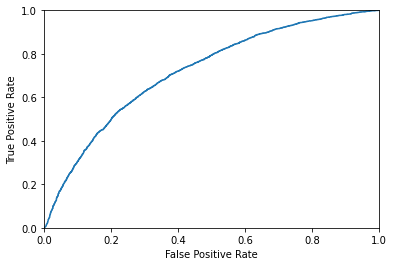

In [41]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr_keras,tpr_keras)

# AUC

In [42]:
 # AUC
 auc_keras

0.7187062421297721

# Ranking Words


*   Used wordcloud to find words associate with a label.
*   A different approach could have been used as explained in this paper https://www.mdpi.com/1999-5903/12/12/228 but due to time constraint I used wordcloud.



In [ ]:
from wordcloud import WordCloud

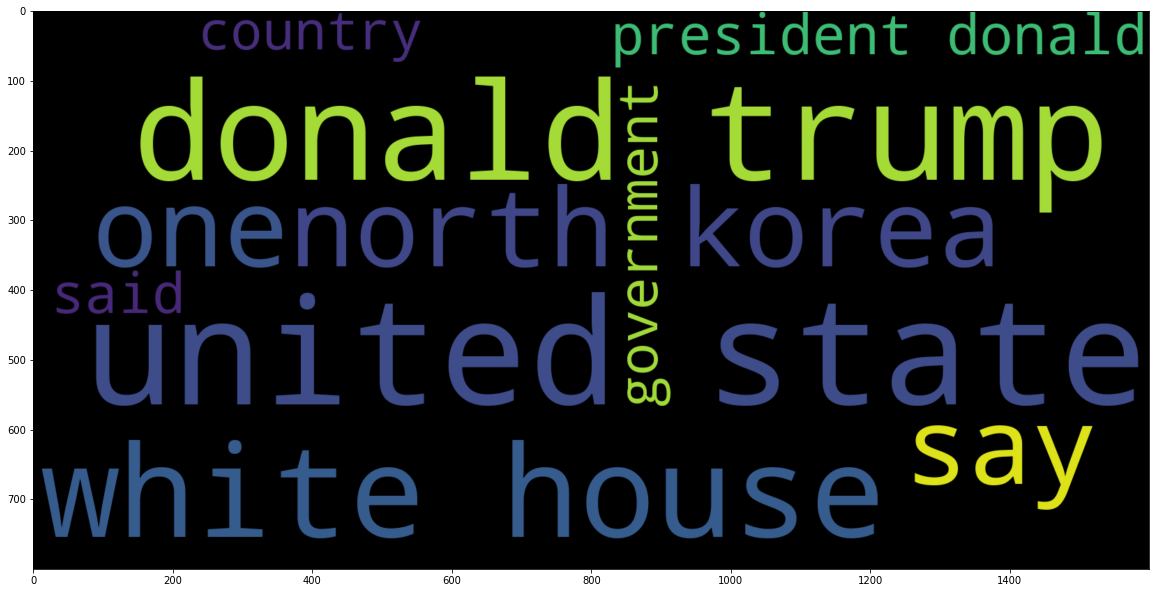

In [ ]:
# 10 most frequent words associated with True News.

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 10, width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(corpus[corpus.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

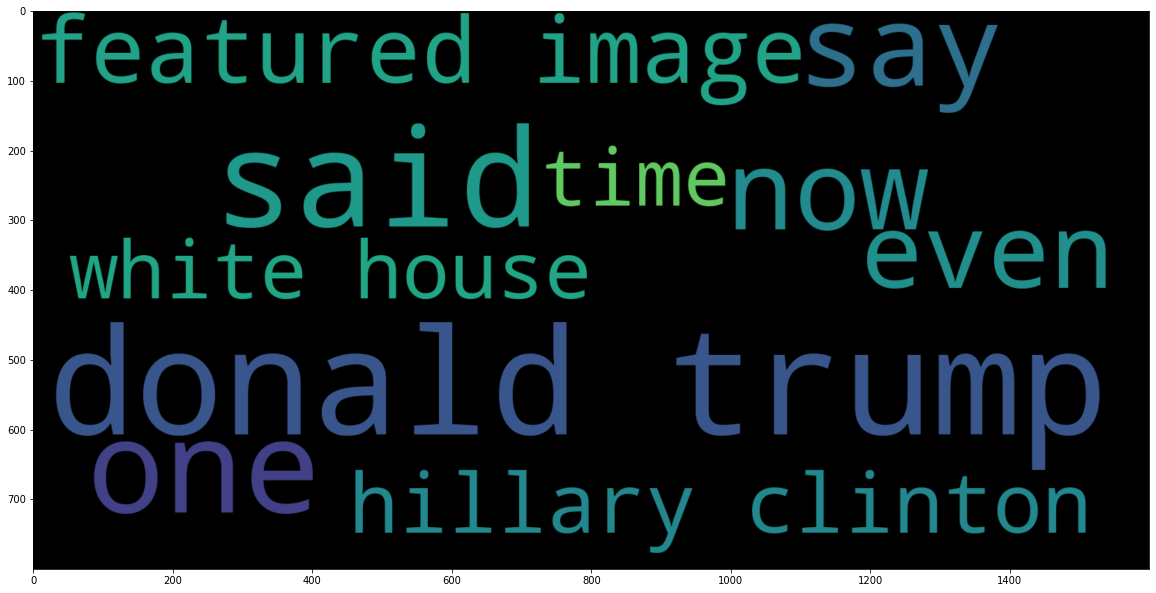

In [ ]:
# 10 most frequent words associated with Fake News.

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 10 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(corpus[corpus.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# Model Performance Enhancement Idea.
The method executed in this notebook included training word embedding from scratch on the provided dataset. By using a pre-trained word embedding such as GloVe might increase performance and reduce computational cost.